# TempAtt exp2: specific analyses of tapping data

### Load & preprocess data

In [ ]:
% !must load the Circular Statistics Toolbox and add it to the Matlab path
% https://fr.mathworks.com/matlabcentral/fileexchange/10676-circular-statistics-toolbox-directional-statistics

In [103]:
clear
clc
% close all

In [104]:
% define Paths: replace XXX by your own path
origDir = '/XXX/exp2/';
addpath(genpath(origDir)); cd(origDir)

% define data
SUJETS = 1:21;
SUJETS(SUJETS==15) = [];

% Load tapping data
load([origDir 'exp2_tapping.mat']); % TAPP & ORAW

In [105]:
% load performance data: 2 sessions per participant
IN = [];
for isuj = SUJETS
    subject = ['S' sprintf( '%02d', isuj ) ];
        ifile = dir(['TA18_' subject '_Listen_1*.mat']);
        load([ifile.name])
        IN{isuj,1}  = X;
    subject = ['S' sprintf( '%02d', isuj ) ];
        ifile = dir(['TA18_' subject '_Tracking_1*.mat']);
        load([ifile.name]) 
        IN{isuj,2}  = X;
    clear X subject ifile
end

In [106]:
% extract data
beats = cfg.fbeat(end:-1:1);
PERF = NaN(SUJETS(end), length(cfg.fbeat), 2, 2*cfg.ntrial);
for isuj = SUJETS
    out = [];
    for itapp = 1:2
        for ibeat = 1:length(beats)
            y = IN{isuj,itapp}.beat == beats(ibeat);
            out{1}(ibeat,itapp,:) = IN{isuj,itapp}.iscor(y);
            out{2}(ibeat,itapp,:) = IN{isuj,itapp}.rt(y);
        end
    end
    % remove RT >2 sec
        rtmax = 2; % in sec
        out{2}(out{2}>rtmax) = NaN; % rt outliers (+2sd)
        out{1}(out{2}>rtmax) = NaN;
    PERF(isuj,:,:,:) = out{1};
end
nbeat = length(beats); ntrial = size(PERF,4);
clear x y rtmax out IN  isuj itapp ibeat cfg subject

% Compute Phase of tapping relative to the beat
LAG = nan(SUJETS(end), nbeat, 1, ntrial);
PHY = nan(SUJETS(end), nbeat);
for isuj = SUJETS
    for ibeat = 1:length(beats)
    phy = NaN(ntrial,1);
        for itrial = 1:ntrial
            ntones = length(ORAW{isuj, ibeat, 1}{itrial} - 1);
            if ntones >= 1
                temp = round( ORAW{isuj,ibeat,1}{itrial} -333 ); % in ms
                temp = mod( temp, 1e3/beats(ibeat)); % circular
                temp = temp*(beats(ibeat)/1e3)*2*pi; % normalized
                LAG(isuj,ibeat,1,itrial) = abs(circ_mean(temp)); % abs mean
                phy(itrial) = circ_mean(temp); % mean
                clear temp ntones
            end
        end
        phy(isnan(phy)) = [];
        PHY(isuj,ibeat) = circ_mean(phy);
    end
end
clear isuj ibeat itrial  ORAW

In [107]:
% remove phantom (NaN) participants
PERF(isnan(nanmean(PERF(:,1,1,:),4)),:,:,:) = [];
TAPP(isnan(nanmean(TAPP(:,1,1,:),4)),:,:,:) = [];
LAG(isnan(nanmean(LAG(:,1,1,:),4)),:,:,:) = [];
PHY(isnan(PHY(:,1)),:) = [];
nsuj  = size(PERF,1);

In [79]:
% save lag data between motor tapping & beat
save('exp2_lag.mat', 'LAG') % LAG

In [109]:
% sort data (2 choices)
Gp = []; rawt = []; rawp = []; T = []; P = [];
for isuj = 1:nsuj
    for ibeat = 1:nbeat
        perf = squeeze(PERF(isuj,ibeat,2,:)); % 1=listen, 2=tracking
        % tapp: cv of tapping-speed
        tapp = squeeze(TAPP(isuj,ibeat,2,:))*100; % 2=cv
            yy = [0, 30]; ynam = 'Coefficient of variation (%)';
        
        Gp(isuj,ibeat, 1) = nanmean(tapp(perf==1)); % sort fn perf
            Gp(isuj,ibeat, 2) = nanmean(tapp(perf==0));        
        [tapp,id] = sort(tapp); perf = perf(id); % sort fn tapp
        rawt(isuj,ibeat, :) = tapp; 
        rawp(isuj,ibeat, :) = perf;        
        T(isuj,ibeat, 1) = nanmean(tapp(1:20)); % sort fn tapp
            T(isuj,ibeat, 2) = nanmean(tapp(21:end));
        P(isuj,ibeat, 1) = nanmean(perf(1:20));
            P(isuj,ibeat, 2) = nanmean(perf(21:end));
    end
end
% replace NaN data (from tapping) by avg across trials (per condition)
for i0 = 1:isuj
    for j0 = 1:ibeat
        for z0 = 1:2
            if isnan(Gp(i0,j0,z0))
                Gp(i0,j0,z0) = nanmean(Gp(:,j0,z0));
            else
                Gp(i0,j0,z0) = Gp(i0,j0,z0);
            end
        end
    end
end
clear perf tapp id isuj ibeat

### Figure

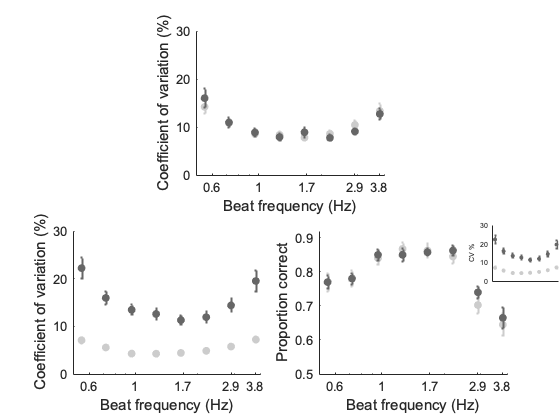

In [110]:
figure; set(gcf,'color','w'); colormap([.5 .5 .5; 1 1 1])

% Figure cv fn perf (correct/incorrect)
subplot(2, 2, 1.5); hold on
    x = Gp(:,:,1); % correct
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'k.', 'color', [.8 .8 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    x = Gp(:,:,2); % error
    x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
    errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
    'k.', 'color', [.4 .4 .4 ], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    if yy(1)== 80; plot(beats, 100*ones(1,nbeat),'k:'); end % if tapspeed
    hold off
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylabel( ynam )        
    xlabel( 'Beat frequency (Hz)' )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
    ylim( yy )
        xticks( round(beats([end:-2:1 1]),1) )
        set(gca, 'XScale', 'log')
        xlim( [.5, 4] )

% Figure: median split of cv
subplot(2, 2, 3); hold on % cv
    x = T(:,:,1); % low
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'b.', 'color', [.8 .8 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    x = T(:,:,2); % high
    x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
    errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
    'r.', 'color', [.4 .4 .4 ], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    if yy(1)== 80; plot(beats, 100*ones(1,nbeat),'k:'); end % if tapspeed
    hold off
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylabel( ynam )        
    xlabel( 'Beat frequency (Hz)' )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
    ylim( yy )
        xticks( round(beats([end:-2:1 1]),1) )
        set(gca, 'XScale', 'log')
        xlim( [.5, 4] )

% Figure: perf fn cv (median split)
subplot(2, 2, 4); hold on % perf
    x = P(:,:,1); % low
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'b.', 'color', [.8 .8 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    x = P(:,:,2); % high
    x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
    errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
    'r.', 'color', [.4 .4 .4 ], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylabel( 'Proportion correct' )
    xlabel( 'Beat frequency (Hz)' )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
    ylim( [.5, .92] )
        xticks( round(beats([end:-2:1 1]),1) )
        set(gca, 'XScale', 'log')
        xlim( [.5, 4] )
        
        ax2 = axes('Position',[.878 .33 .2/1.7 .2/1.5]); hold on;
          x = T(:,:,1); % low
            x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
            errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
            'b.', 'color', [.8 .8 .8], 'MarkerSize',7, 'Linewidth', 1, 'CapSize',1)
            x = T(:,:,2); % high
            x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
           errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
            'r.', 'color', [.4 .4 .4 ], 'MarkerSize',7, 'Linewidth', 1, 'CapSize',1)
            if yy(1)== 80; plot(beats, 100*ones(1,nbeat),'k:'); end % if tapspeed
            hold off
            set(gca, 'FontSize', 5, 'FontName', 'Arial')
            ylabel( 'CV %' )        
            %xlabel( 'Beat frequency (Hz)' )
           % set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
            ylim( yy )
               % xticks( round(beats([end:-2:1 1]),1) )
                set(gca, 'XScale', 'log')
                xticks( [] )
                xlim( [.5, 4] )
            clear x s

% Print figure
cd(origDir)
% print('figureS2b&c','-dpng','-r600')
f.PaperSize = [46.81 33.1];
f.PaperPosition(1:2) = [0 0];
print -dpdf figureS2b&c.pdf


### Statistics

In [111]:
% 1. Anova on corr - incorr
X = Gp;
X(sum(sum(isnan(X),2),3)>0,:,:) = [];

fprintf('\n1.Parametric repeated-measure Anova on performance corr - incorr \n')
[efs,F,cdfs,p,eps,dfs,b,y2,sig] = repanova(reshape(X, size(X,1), []), [2, 8], {'cor/inc', 'Beat'});
bf = bftest(diff(mean(X,2),[],3),'bic'); fprintf('BF = %2.2f\n', bf);

% 2. control anova on median split of CV
fprintf('\n2. Parametric repeated-measure Anova on Coeff variation (control) median split of CV \n')
[~,F,~,~] = repanova(reshape(T, size(T,1), []), [2, 8], {'low/high', 'Beat'});
bf = bftest(diff(mean(T,2),[],3),'bic'); fprintf('BF = %2.2f\n', bf);

% 3. Anova on perf CV high - CV low
fprintf('\n3. Parametric repeated-measure Anova on performance CV high - CV low \n')
[~,F,~,~] = repanova(reshape(P, size(T,1), []), [2, 8], {'low/high', 'Beat'});
bf = bftest(diff(mean(P,2),[],3),'bic'); fprintf('BF = %2.2f\n', bf);
clear X bf F


1.Parametric repeated-measure Anova on performance corr - incorr 
cor/inc              F(  1.00, 19.00) =   0.000,	p = 0.9879
Beat                 F(  7.00,133.00) =   7.090,	p = 0.0004
cor/inc x Beat       F(  7.00,133.00) =   1.144,	p = 0.3428
BF = 0.22

2. Parametric repeated-measure Anova on Coeff variation (control) median split of CV 
low/high             F(  1.00, 19.00) =  79.714,	p = 0.0000
Beat                 F(  7.00,133.00) =   6.823,	p = 0.0005
low/high x Beat      F(  7.00,133.00) =   4.409,	p = 0.0032
BF = 3204310.71

3. Parametric repeated-measure Anova on performance CV high - CV low 
low/high             F(  1.00, 19.00) =   0.422,	p = 0.5235
Beat                 F(  7.00,133.00) =  16.126,	p = 0.0000
low/high x Beat      F(  7.00,133.00) =   0.468,	p = 0.7901
BF = 0.28


In [112]:
% Analyse performance fn tapping/beat Lag & vice-versa

% sort data
Gp = []; rawt = []; rawp = []; T = []; P = [];
for isuj = 1:nsuj
    for ibeat = 1:nbeat
        perf = squeeze(PERF(isuj,ibeat,2,:)); % 1=listen, 2=tracking
        tapp = squeeze(LAG(isuj,ibeat,1,:)); % lag
            yy = [0, 2]; ynam = '|\phi tapping-beat| (rad)';
        
        Gp(isuj,ibeat, 1) = nanmean(tapp(perf==1)); % sort fn perf
            Gp(isuj,ibeat, 2) = nanmean(tapp(perf==0));        
        [tapp,id] = sort(tapp); perf = perf(id); % sort fn tapp
        rawt(isuj,ibeat, :) = tapp; 
        rawp(isuj,ibeat, :) = perf;        
        T(isuj,ibeat, 1) = nanmean(tapp(1:20)); % sort fn tapp
            T(isuj,ibeat, 2) = nanmean(tapp(21:end));
        P(isuj,ibeat, 1) = nanmean(perf(1:20));
            P(isuj,ibeat, 2) = nanmean(perf(21:end));
    end
end
for i0 = 1:isuj
    for j0 = 1:ibeat
        for z0 = 1:2
            if isnan(Gp(i0,j0,z0))
                Gp(i0,j0,z0) = nanmean(Gp(:,j0,z0));
            else
                Gp(i0,j0,z0) = Gp(i0,j0,z0);
            end
        end
    end
end
clear perf tapp id isuj ibeat
% Gp(sum(sum(isnan(Gp),2),3)>0,:,:) = []; % remove NaN participant


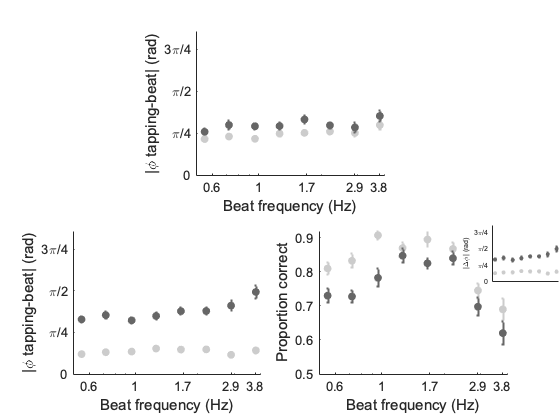

In [113]:
figure; set(gcf,'color','w'); colormap([.5 .5 .5; 1 1 1])

% Figure lag fn perf (correct/incorrect)
subplot(2, 2, 1.5); hold on
    x = Gp(:,:,1); % correct
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'b.', 'color', [.8 .8 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    x = Gp(:,:,2); % error
    x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
    errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
    'r.', 'color', [.4 .4 .4 ], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    hold off
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylabel( ynam )        
    xlabel( 'Beat frequency (Hz)' )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
	ylim( [0, 2.7] )
    yticks( [0 pi/4 pi/2 3*pi/4] )
    yticklabels({'0','\pi/4','\pi/2', '3\pi/4'})
        xticks( round(beats([end:-2:1 1]),1) )       
        set(gca, 'XScale', 'log')
        xlim( [.5, 4] )


% Figure: median split of cv 
subplot(2, 2, 3); hold on % cv
    x = T(:,:,1); % low
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'b.', 'color', [.8 .8 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    x = T(:,:,2); % high
    x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
    errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
    'r.', 'color', [.4 .4 .4 ], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    hold off
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylabel( ynam )        
    xlabel( 'Beat frequency (Hz)' )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
	ylim( [0, 2.7] )
    yticks( [0 pi/4 pi/2 3*pi/4] )
    yticklabels({'0','\pi/4','\pi/2', '3\pi/4'})
        xticks( round(beats([end:-2:1 1]),1) )
        set(gca, 'XScale', 'log')
        xlim( [.5, 4] )

% Figure: perf fn cv (median split)
subplot(2, 2, 4); hold on % perf
    x = P(:,:,1); % low
    x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
    errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
    'b.', 'color', [.8 .8 .8], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    x = P(:,:,2); % high
    x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
    errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
    'r.', 'color', [.4 .4 .4 ], 'MarkerSize',15, 'Linewidth', 1.5,'Capsize', 1)
    hold off
    set(gca, 'FontSize', 10, 'FontName', 'Arial')
    ylabel( 'Proportion correct' )
    xlabel( 'Beat frequency (Hz)' )
    set(gca,'Layer','top','Box','off','TickLength',[.01 .01])
    ylim( [.5, .92] )
        xticks( round(beats([end:-2:1 1]),1) )
        set(gca, 'XScale', 'log')
        xlim( [.5, 4] )
        
    ax2 = axes('Position',[.878 .33 .2/1.7 .2/1.5]); hold on;
          x = T(:,:,1); % low
            x = bsxfun(@plus,bsxfun(@minus, x, mean(x,2)), mean(x(:)));
            errorbar(beats, mean(x), std(x)/sqrt(size(x,1)), ...
            'b.', 'color', [.8 .8 .8], 'MarkerSize',7, 'Linewidth', 1, 'CapSize',1)
            x = T(:,:,2); % high
            x = bsxfun(@plus,bsxfun(@minus, x, nanmean(x,2)), nanmean(x(:)));
           errorbar(beats, nanmean(x), nanstd(x)/sqrt(size(x,1)), ...
            'r.', 'color', [.4 .4 .4 ], 'MarkerSize',7, 'Linewidth', 1, 'CapSize',1)
            if yy(1)== 80; plot(beats, 100*ones(1,nbeat),'k:'); end % if tapspeed
            hold off
            set(gca, 'FontSize', 5, 'FontName', 'Arial')
            ylabel( '|\Delta\phi| (rad)' ) 
            ylim( [0, 2.7] )
            yticks( [0 pi/4 pi/2 3*pi/4] )
            yticklabels({'0','\pi/4','\pi/2', '3\pi/4'})
                set(gca, 'XScale', 'log')
                xticks( [] )
                xlim( [.5, 4] )          
 
% Print figure
cd(origDir)
% print('figure2e&f','-dpng','-r600')
f.PaperSize = [46.81 33.1];
f.PaperPosition(1:2) = [0 0];
print -dpdf figure2e&f.pdf


In [114]:
fprintf('\n1.Parametric repeated-measure Anova on performance \n')
[~,F,~,~] = repanova(reshape(Gp, size(Gp,1), []), [2, 8], {'cor/inc', 'Beat'});
bf = bftest(diff(mean(Gp,2),[],3),'aic'); fprintf('BF = %2.2f\n', bf);

fprintf('\n2. Parametric repeated-measure Anova on Coeff variation (control) \n')
[~,F,~,~] = repanova(reshape(T, size(T,1), []), [2, 8], {'low/high', 'Beat'});

fprintf('\n3. Parametric repeated-measure Anova on performance \n')
[~,F,~,~] = repanova(reshape(P, size(T,1), []), [2, 8], {'low/high', 'Beat'});
bf = bftest(diff(mean(P,2),[],3),'aic'); fprintf('BF = %2.2f\n', bf);

% Post-hoc analysis: low vs. high lag (beat-by-beat)
fprintf('\n')
for j0 = 1:length(beats)
    [~, p, ~, S] = ttest(P(:,j0,1), P(:,j0,2));
    bf = bftest(P(:,j0,2)-P(:,j0,1),'bic'); 
    fprintf('     beat %1.2fhz: p= %6.4f,  t= %6.4f,  df= %6.4f,  bf= %6.4f\n', beats(j0), p, S.tstat, S.df, bf)
    pval(j0) = p;
end

clear x h T P F bf


1.Parametric repeated-measure Anova on performance 
cor/inc              F(  1.00, 19.00) =  23.399,	p = 0.0001
Beat                 F(  7.00,133.00) =   1.865,	p = 0.1474
cor/inc x Beat       F(  7.00,133.00) =   0.796,	p = 0.5545
BF = 907.83

2. Parametric repeated-measure Anova on Coeff variation (control) 
low/high             F(  1.00, 19.00) = 209.010,	p = 0.0000
Beat                 F(  7.00,133.00) =   2.297,	p = 0.0976
low/high x Beat      F(  7.00,133.00) =  11.836,	p = 0.0000

3. Parametric repeated-measure Anova on performance 
low/high             F(  1.00, 19.00) =  30.808,	p = 0.0000
Beat                 F(  7.00,133.00) =  16.126,	p = 0.0000
low/high x Beat      F(  7.00,133.00) =   1.620,	p = 0.1602
BF = 4543.73

     beat 3.82hz: p= 0.0468,  t= 2.1259,  df= 19.0000,  bf= 1.8889
     beat 2.90hz: p= 0.1247,  t= 1.6061,  df= 19.0000,  bf= 0.7987
     beat 2.20hz: p= 0.3215,  t= 1.0179,  df= 19.0000,  bf= 0.3803
     beat 1.66hz: p= 0.0216,  t= 2.5039,  df= 19.0000,  bf

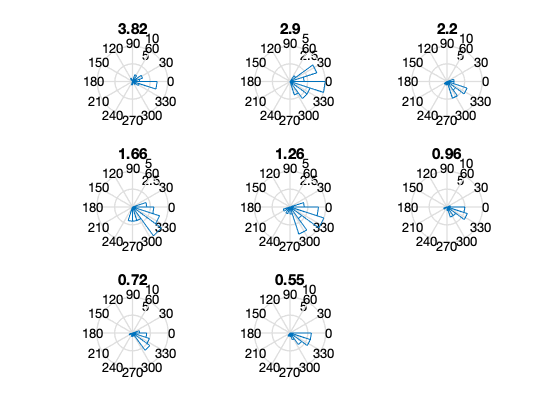

In [117]:
% Figure phase value
f=figure; set(gcf,'color','w'); colormap([.5 .5 .5; 1 1 1]);
for ibeat = 1:nbeat
    subplot(3,3,ibeat)
    rose(PHY(:,ibeat)) % the function used to create figure S4 is homemade and can be requested to the corresponding author
    title(num2str(beats(ibeat)))
end


